In [1]:
# 데이터 불러오기
import os
import numpy as np
import random
import shutil

train_path = "./data/Train/"
test_path = "./data/Test/"

In [2]:
import matplotlib.image as mpimg

def read_images_from_path(path):
    image_files = [f for f in os.listdir(path) if f.endswith(".jpg")]
    images = [os.path.join(path, f) for f in image_files]
    return images

def images_to_numpy(images):
    image_arrays = [mpimg.imread(image_path) for image_path in images]
    return np.array(image_arrays)

# 각 경로에서 모든 이미지를 읽어와서 numpy 배열로 변환
images_normal = read_images_from_path(train_path + "normal")
numpy_array_normal = images_to_numpy(images_normal)

images_mild = read_images_from_path(train_path + "mild")
numpy_array_mild = images_to_numpy(images_mild)

# 넘파이 배열의 크기 확인
print("Non Demented Shape:", numpy_array_normal.shape)
print("Mild Demented Shape:", numpy_array_mild.shape)

Non Demented Shape: (2560, 128, 128)
Mild Demented Shape: (716, 128, 128)


In [3]:
def one_hot_encode(labels, num_classes):
    return np.eye(num_classes)[labels.astype(int)]

# 각 클래스에 대한 레이블 생성
num_classes = 2  # 클래스 개수에 따라 조절
labels_normal = one_hot_encode(np.zeros(len(numpy_array_normal)), num_classes)
labels_mild = one_hot_encode(np.ones(len(numpy_array_mild)), num_classes)

# 데이터 확인
print("Non Demented Labels Shape:", labels_normal.shape)
print("Mild Demented Labels Shape:", labels_mild.shape)

# y 변수 생성
y_Non_Demented = labels_normal
y_Mild_Demented = labels_mild

Non Demented Labels Shape: (2560, 2)
Mild Demented Labels Shape: (716, 2)


In [4]:
print(y_Non_Demented[:2])
print(y_Mild_Demented[:2])

[[1. 0.]
 [1. 0.]]
[[0. 1.]
 [0. 1.]]


In [5]:
# Non_Demented, Mild_Demented 데이터 합치기
X_train = np.concatenate((numpy_array_normal, numpy_array_mild), axis=0)

# 각 데이터에 대한 레이블 합치기
y_train = np.concatenate((y_Non_Demented, y_Mild_Demented), axis=0)

# 데이터와 레이블의 형태 확인
print("X_train Shape:", X_train.shape)
print("y_train Shape:", y_train.shape)

# 데이터와 레이블을 함께 섞기
indices = np.arange(X_train.shape[0])
np.random.shuffle(indices)

X_train = X_train[indices]
X_train = np.reshape(X_train, (-1,128,128,1))
y_train = y_train[indices]

X_train = X_train / 255.

# 섞인 데이터와 레이블의 형태 확인
print("Shuffled X_train Shape:", X_train.shape)
print("Shuffled y_train Shape:", y_train.shape)

X_train Shape: (3276, 128, 128)
y_train Shape: (3276, 2)
Shuffled X_train Shape: (3276, 128, 128, 1)
Shuffled y_train Shape: (3276, 2)


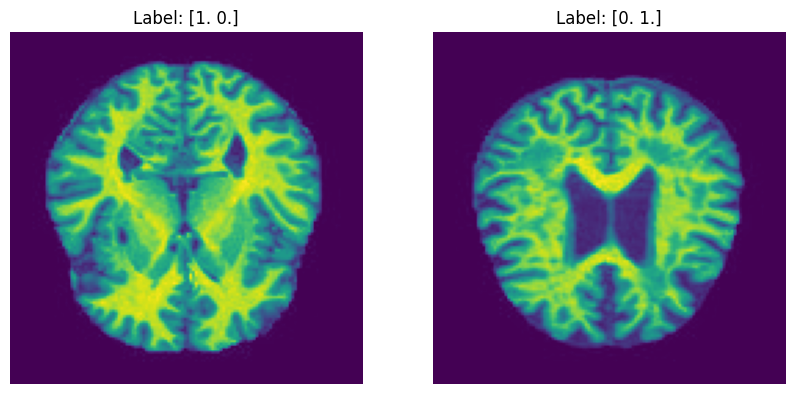

In [6]:
import matplotlib.pyplot as plt
# 원하는 레이블에 해당하는 이미지 무작위로 선택
desired_labels = np.array([[1, 0], [0, 1]])
selected_images = []
selected_labels = []

for label in desired_labels:
    # 해당 레이블에 해당하는 인덱스 추출
    indices = np.where((y_train == label).all(axis=1))[0]
    
    # 해당 인덱스 중 무작위로 1개 선택
    random_index = np.random.choice(indices, 1)[0]
    
    # 이미지 및 레이블 저장
    selected_images.append(X_train[random_index])
    selected_labels.append(y_train[random_index])

# 선택한 이미지 플로팅
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i in range(2):
    axes[i].imshow(selected_images[i])
    axes[i].set_title(f"Label: {selected_labels[i]}")
    axes[i].axis('off')

plt.show()

In [7]:
import matplotlib.image as mpimg

# 각 경로에서 모든 이미지를 읽어와서 numpy 배열로 변환
images_normal = read_images_from_path(test_path + "normal")
numpy_array_normal = images_to_numpy(images_normal)

images_mild = read_images_from_path(test_path + "mild")
numpy_array_mild = images_to_numpy(images_mild)

# 각 클래스에 대한 레이블 생성
num_classes = 2  # 클래스 개수에 따라 조절
labels_normal = one_hot_encode(np.zeros(len(numpy_array_normal)), num_classes)
labels_mild = one_hot_encode(np.ones(len(numpy_array_mild)), num_classes)

# y 변수 생성
y_Non_Demented = labels_normal
y_Mild_Demented = labels_mild

# Moderate_Demented, Non_Demented, Very_Mild_Demented 데이터 합치기
X_test = np.concatenate((numpy_array_normal, numpy_array_mild), axis=0)

# 각 데이터에 대한 레이블 합치기
y_test = np.concatenate((y_Non_Demented, y_Mild_Demented), axis=0)

# 데이터와 레이블의 형태 확인
print("X_train Shape:", X_test.shape)
print("y_train Shape:", y_test.shape)

# 데이터와 레이블을 함께 섞기
indices = np.arange(X_test.shape[0])
np.random.shuffle(indices)

X_test = X_test[indices]
X_test = np.reshape(X_test, (-1,128,128,1))
X_test = X_test / 255.
y_test = y_test[indices]

# 섞인 데이터와 레이블의 형태 확인
print("Shuffled X_test Shape:", X_test.shape)
print("Shuffled y_test Shape:", y_test.shape)

X_train Shape: (820, 128, 128)
y_train Shape: (820, 2)
Shuffled X_test Shape: (820, 128, 128, 1)
Shuffled y_test Shape: (820, 2)


In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# F1 Score를 저장할 리스트
f1_scores_train = []
f1_scores_test = []

for i in range(5):
    # 모델 초기화 및 정의
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(2, activation='softmax')  # 클래스 개수에 맞춰 조절
    ])
    
    # 모델 컴파일
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    # 데이터 학습
    model.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.2, verbose=0)
    
    # 훈련 데이터 예측 및 F1 스코어 계산
    y_pred_train = model.predict(X_train)
    y_pred_labels_train = np.argmax(y_pred_train, axis=1)
    y_true_labels_train = np.argmax(y_train, axis=1)
    f1_train = f1_score(y_true_labels_train, y_pred_labels_train, average='weighted')
    f1_scores_train.append(f1_train)
    
    # 테스트 데이터 예측 및 F1 스코어 계산
    y_pred_test = model.predict(X_test)
    y_pred_labels_test = np.argmax(y_pred_test, axis=1)
    y_true_labels_test = np.argmax(y_test, axis=1)
    f1_test = f1_score(y_true_labels_test, y_pred_labels_test, average='weighted')
    f1_scores_test.append(f1_test)
    
    # 각 실험의 F1 Score 출력
    print(f"Experiment {i+1} - Train F1 Score: {f1_train:.8f}, Test F1 Score: {f1_test:.8f}")

# 훈련 데이터 F1 스코어의 평균과 표준편차
f1_mean_train = np.mean(f1_scores_train)
f1_std_train = np.std(f1_scores_train)

# 테스트 데이터 F1 스코어의 평균과 표준편차
f1_mean_test = np.mean(f1_scores_test)
f1_std_test = np.std(f1_scores_test)

# F1 스코어 배열 형식으로 출력
print("\nTest Data F1 Scores (Array Format):")
print(f1_scores_test)

# 결과 출력
print("\nFinal Results:")
print(f"Training Data - F1 Score Mean: {f1_mean_train:.8f}, Std: {f1_std_train:.8f}")
print(f"Test Data - F1 Score Mean: {f1_mean_test:.8f}, Std: {f1_std_test:.8f}")

2024-09-12 08:53:15.988418: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-12 08:53:16.089785: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-12 08:53:17.871340: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-09-12 08:53:22.225278: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38366 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:3b:00.0, compute capab

26/26 [==============================] - 0s 10ms/step
Experiment 1 - Train F1 Score: 0.99969467, Test F1 Score: 0.99512195
26/26 [==============================] - 0s 4ms/step
Experiment 2 - Train F1 Score: 0.99847336, Test F1 Score: 0.99022426
26/26 [==============================] - 0s 4ms/step
Experiment 3 - Train F1 Score: 0.99847336, Test F1 Score: 0.99268293
26/26 [==============================] - 0s 4ms/step
Experiment 4 - Train F1 Score: 0.99908402, Test F1 Score: 0.99388395
26/26 [==============================] - 0s 4ms/step
Experiment 5 - Train F1 Score: 0.99877838, Test F1 Score: 0.99634510

Test Data F1 Scores (Array Format):
[0.9951219512195122, 0.9902242608303595, 0.9926829268292683, 0.993883947891268, 0.9963451004065983]

Final Results:
Training Data - F1 Score Mean: 0.99890076, Std: 0.00045699
Test Data - F1 Score Mean: 0.99365164, Std: 0.00210503


In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.metrics import f1_score

# F1 Score를 저장할 리스트
f1_scores_train = []
f1_scores_test = []

for i in range(5):
    # VGG16 유사 모델 정의
    model = models.Sequential([
        # 첫 번째 컨볼루션 블록
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 1)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2), strides=(2, 2)),

        # 두 번째 컨볼루션 블록
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2), strides=(2, 2)),

        # 세 번째 컨볼루션 블록
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2), strides=(2, 2)),

        # 네 번째 컨볼루션 블록
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2), strides=(2, 2)),

        # 다섯 번째 컨볼루션 블록
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2), strides=(2, 2)),

        # 분류기
        layers.Flatten(),
        layers.Dense(4096, activation='relu'),
        layers.Dense(4096, activation='relu'),
        layers.Dense(2, activation='softmax')
    ])

    # 모델 컴파일
    model.compile(optimizer=Adam(learning_rate=0.00005),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    # 데이터 학습, 로그 출력 비활성화
    model.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.2, verbose=0)
    
    # 훈련 데이터 예측 및 F1 스코어 계산
    y_pred_train = model.predict(X_train)
    y_pred_labels_train = np.argmax(y_pred_train, axis=1)
    y_true_labels_train = np.argmax(y_train, axis=1)
    f1_train = f1_score(y_true_labels_train, y_pred_labels_train, average='weighted')
    f1_scores_train.append(f1_train)
    
    # 테스트 데이터 예측 및 F1 스코어 계산
    y_pred_test = model.predict(X_test)
    y_pred_labels_test = np.argmax(y_pred_test, axis=1)
    y_true_labels_test = np.argmax(y_test, axis=1)
    f1_test = f1_score(y_true_labels_test, y_pred_labels_test, average='weighted')
    f1_scores_test.append(f1_test)
    
    # 각 실험의 F1 Score 출력
    print(f"Experiment {i+1} - Train F1 Score: {f1_train:.8f}, Test F1 Score: {f1_test:.8f}")

# 훈련 데이터 F1 스코어의 평균과 표준편차
f1_mean_train = np.mean(f1_scores_train)
f1_std_train = np.std(f1_scores_train)

# 테스트 데이터 F1 스코어의 평균과 표준편차
f1_mean_test = np.mean(f1_scores_test)
f1_std_test = np.std(f1_scores_test)

# F1 스코어 배열 형식으로 출력
print("\nTest Data F1 Scores (Array Format):")
print(f1_scores_test)

# 결과 출력
print("\nFinal Results:")
print(f"Training Data - F1 Score Mean: {f1_mean_train:.8f}, Std: {f1_std_train:.8f}")
print(f"Test Data - F1 Score Mean: {f1_mean_test:.8f}, Std: {f1_std_test:.8f}")

26/26 [==============================] - 1s 27ms/step
Experiment 1 - Train F1 Score: 0.95875644, Test F1 Score: 0.94823553
26/26 [==============================] - 0s 9ms/step
Experiment 2 - Train F1 Score: 0.93263223, Test F1 Score: 0.89906588
26/26 [==============================] - 0s 9ms/step
Experiment 3 - Train F1 Score: 0.96998793, Test F1 Score: 0.93750906
26/26 [==============================] - 0s 9ms/step
Experiment 4 - Train F1 Score: 0.95767721, Test F1 Score: 0.94289730
26/26 [==============================] - 0s 9ms/step
Experiment 5 - Train F1 Score: 0.95518519, Test F1 Score: 0.93929093

Test Data F1 Scores (Array Format):
[0.9482355286922208, 0.8990658820987558, 0.937509060282632, 0.9428972956006251, 0.9392909346249748]

Final Results:
Training Data - F1 Score Mean: 0.95484780, Std: 0.01221599
Test Data - F1 Score Mean: 0.93339974, Std: 0.01755398
